# MOSMAFS -  Multi-objective vs. Single-objective

### Research questions: 

* _Evolutionary vs. Bayesian Optimization_: How do the proposed methods - the evolutionary and the Bayesian optimization approach - perform in comparison to each other?
* _Effect of Filter Ensembles_: Do the methods benefit from using filter ensembles?
* **_Multi-Objective vs. Single-Objective_**: Does multi-objective optimization find much sparser solutions without a major loss in predictive performance compared to single-objective optimization? 
* _Simultaneous Hyperparameter Tuning and Feature Selection_: Is it beneficial to perform hyperparameter optimization and feature selection simultaneously compared to performing the tasks independently? 

## Setup

In [6]:
# Load packages 
library(data.table)
library(reshape2)
library(mlr)
library(ggplot2)
library(batchtools)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(plyr)
library(scmamp)
library(xtable)

In [7]:
# stetup for nice plots 
theme_set(theme_pubr())
options(repr.plot.width=15, repr.plot.height=15)

In [8]:
source("../helpers.R")

In [9]:
# path where all results are stored 
respath = "result_data"

In [10]:
# datasets included in the benchmark 
datasets = c("sonar", "ionosphere",
	"hill-valley", "wdbc", "tecator", "lsvt", "isolet", "cnae-9", 
	"clean1", "semeion", "AP_Breast_Colon", "arcene", 
	"AP_Colon_Kidney", "madelon", "madeline")
datasets = c("sonar", "ionosphere",
	"hill-valley", "wdbc", "tecator", "lsvt", "isolet", "cnae-9", 
	"semeion", "madeline", "madelon")

In [11]:
tab = lapply(datasets, function(d) {
    task = readRDS(file.path("../data", d, "task.rds"))
    class.dist = task$task.desc$class.distribution
    cr = min(class.dist) / sum(class.dist)
    data.table(id = getTaskId(task), n = getTaskSize(task), p = getTaskNFeats(task), class.ratio = cr)
    })
tab = do.call(rbind, tab)

tab$np.ratio = tab$n / tab$p 
tab = tab[order(p), ]
tab = cbind(1:nrow(tab), tab)

In [12]:
tab

V1,id,n,p,class.ratio,np.ratio
<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1,wdbc,569,30,0.3725835,18.9666667
2,ionosphere,351,33,0.3589744,10.6363636
3,sonar,208,60,0.4663462,3.4666667
4,hill-valley,1212,100,0.4950495,12.1200000
5,tecator,240,124,0.4250000,1.9354839
6,semeion,319,256,0.4952978,1.2460938
7,madeline,3140,259,0.4971338,12.1235521
8,cnae-9,240,282,0.5000000,0.8510638
9,lsvt,126,307,0.3333333,0.4104235


The versions we compare are: 

The versions we compare are: 

|Variant | Description | MO / SO | Internal Name |  |
|---|---|---|---|---|
|GA-MO-FE| GA-based Algorithm | MO | OGHFiFm |   |
|BO-MO-FE | BO-based Algorithm | MO | BSMOF |    |
|BO-SO | BO-based Algorithm | SO |  BS2RF | "State-of-the-art", no feature ensembles  |
|BO-SO-FE | BO-based Algorithm | MO | BS2RF_ENS |  Our best candidate for SO, feature ensembles  |

In [13]:
# Experiments to compare
variants_internal = c("OGHFiFmS", "BSMOF", "BS2RF", "BS2RF_ENS")
variants = c("GA-MO-FE", "BO-MO-FE", "BO-SO", "BO-SO-FE")
names(variants) = variants_internal # for revaluing later 

In [14]:
args = readRDS("result_data/populations/args.rds")

In [15]:
args

v,d,job.id
<chr>,<chr>,<int>
BS1RF,AP_Breast_Colon,1
BS1RF,AP_Colon_Kidney,2
BS1RF,arcene,3
BS1RF,clean1,4
BS1RF,cnae-9,5
BS1RF,hill-valley,6
BS1RF,ionosphere,7
BS1RF,isolet,8
BS1RF,lsvt,9


In [33]:
savedir = "result_data/populations/results"
args = readRDS("result_data/populations/args.rds")
args = args[v %in% variants_internal & d %in% datasets, ]
dirs = paste(savedir, "/", args$job.id, ".rds", sep = "")
pops = lapply(dirs, function(dir) {
    f = readRDS(dir)
    bla = lapply(1:100 * 20, function(i) {
        f = f[evals <= i, ]
        f$maxiters = i
        f = f[, .SD[which.min(perf.perf)], by = c("job.id")]
        f
    })
    do.call(rbind, bla)
})

In [34]:
names = Reduce(intersect, lapply(pops, names))
pops = lapply(pops, function(x) x[, ..names])

In [35]:
pops = do.call(rbind, pops)

In [36]:
pops$variant = revalue(pops$variant, variants)

In [21]:
# pops = pops[, replication := 1:length(job.id), by = c("learner", "variant", "problem")]

In [37]:
# workaround to get replications
pops2 = pops[, .SD[which.min(perf.perf)], by = c("problem", "learner", "variant", "job.id")]
pops2 = pops2[, replication := 1:length(job.id), by = c("learner", "variant", "problem")]
pops = ijoin(pops, pops2[, c("job.id", "replication", "learner", "variant")], by = c("job.id", "learner", "variant"))

In [39]:
pops_help = pops[problem == "madelon" & variant == "BO-SO-FE", ]
pops_help$variant = "BO-SO"
pops_help$job.id = pops_help$job.id + 100000

In [44]:
pops = rbind(pops, pops_help)
table(pops[problem == "madelon", ]$variant)


BO-MO-FE    BO-SO BO-SO-FE GA-MO-FE 
    2910     2910     2910     2910 

## Analysis

### a) Measure Overall best Single-Objective Performance

In [45]:
# aggreagte the mean performance across all replications
pops$perf.hout.perf = as.numeric(pops$perf.hout.perf)
pops$perf.perf = as.numeric(pops$perf.perf)

dfr = pops[, .(meanhoutperf = mean(perf.hout.perf)), by = c("learner", "variant", "maxiters", "problem")]
dfr = dfr[, `:=` (rank_variant = rank(meanhoutperf)), by = c("learner", "problem", "maxiters")]
dfr = dfr[, .(meanrank = mean(rank_variant), meanhoutperf = mean(meanhoutperf)), by = c("learner", "maxiters", "variant")]

In [46]:
dfr$Variant = sapply(dfr$variant, function(x) {
    if (x %in% c("BO-MO-FE", "GA-MO-FE")) "MO"
    else "SO"
})

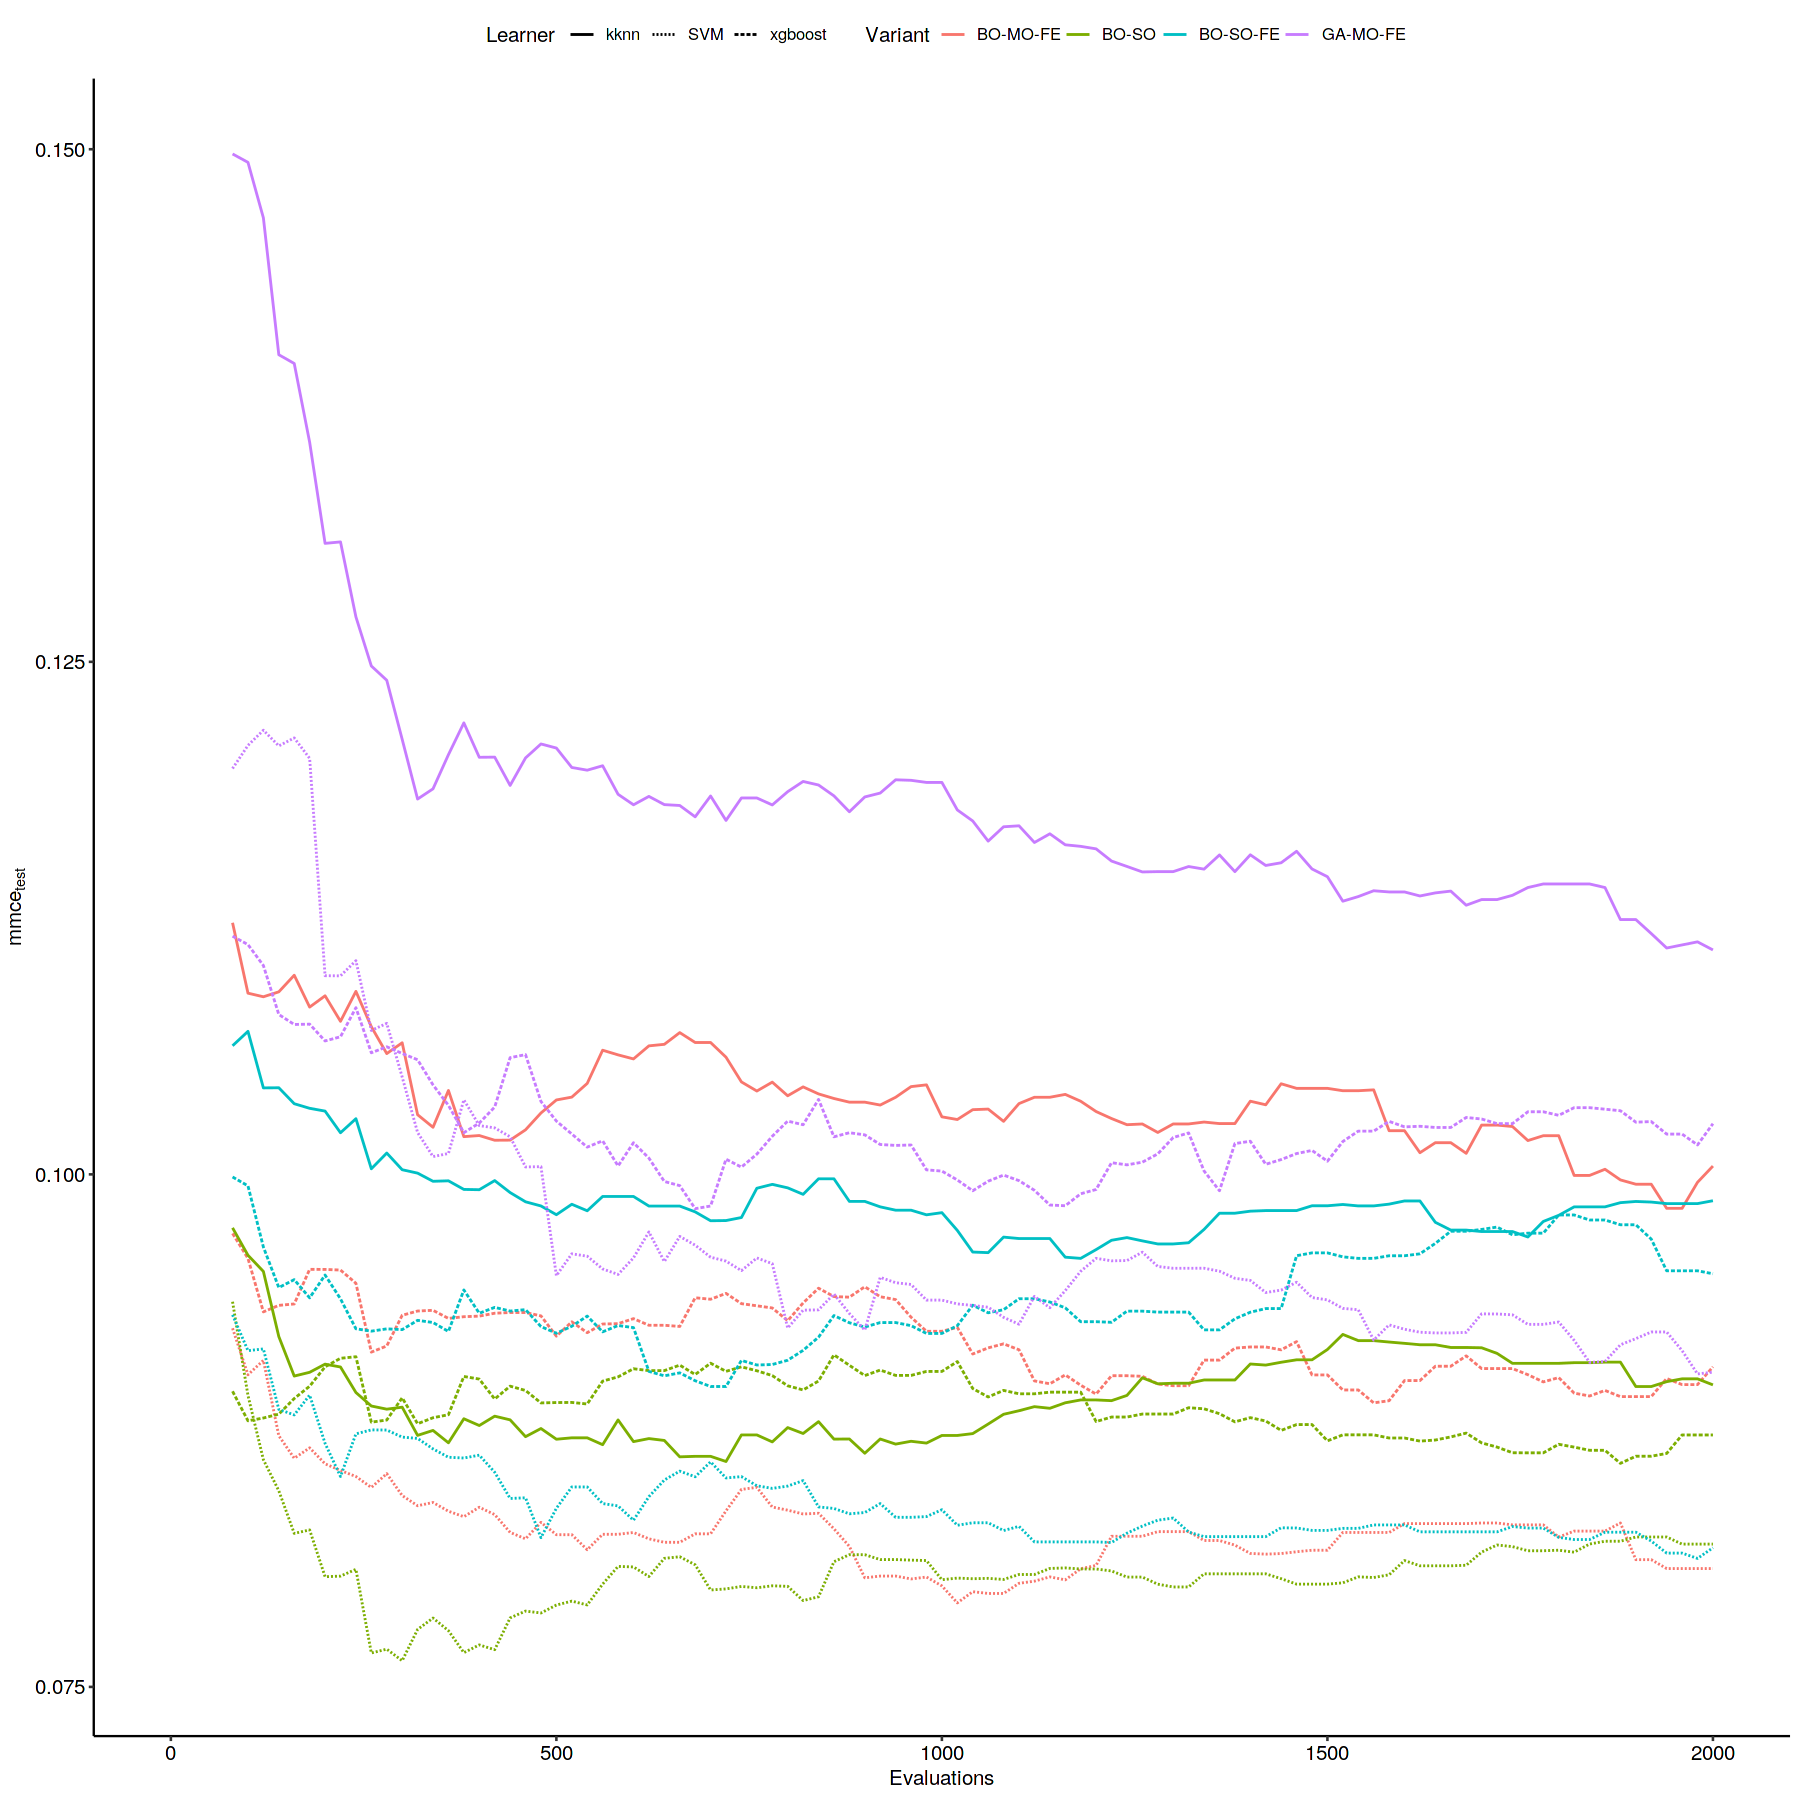

In [47]:
# example
p1 = ggplot()
p1 = p1 + geom_line(data = dfr, aes(x = maxiters, y = meanhoutperf, colour = variant, lty = learner), size = 0.6)
p1 = p1 + labs(colour = "Variant", lty = "Learner") 
p1 = p1 + xlab("Evaluations") + ylab(expression(mmce[test])) + theme(legend.direction = "horizontal")
# p1 = p1 + guides(shape = guide_legend(order = 2),col = guide_legend(order = 1), fill = FALSE)
# p1 = p1 + geom_label(data = res_ovr[evals == 2000, ], aes(x = evals + 150, y = mean.rank, fill = Variant, label = variant), alpha = 0.2)
p1 = p1 + xlim(c(0, 2000)) 
p1

In [48]:
ggsave("viz/RQ3-best-mmce.pdf", p1, width = 9, height = 5)

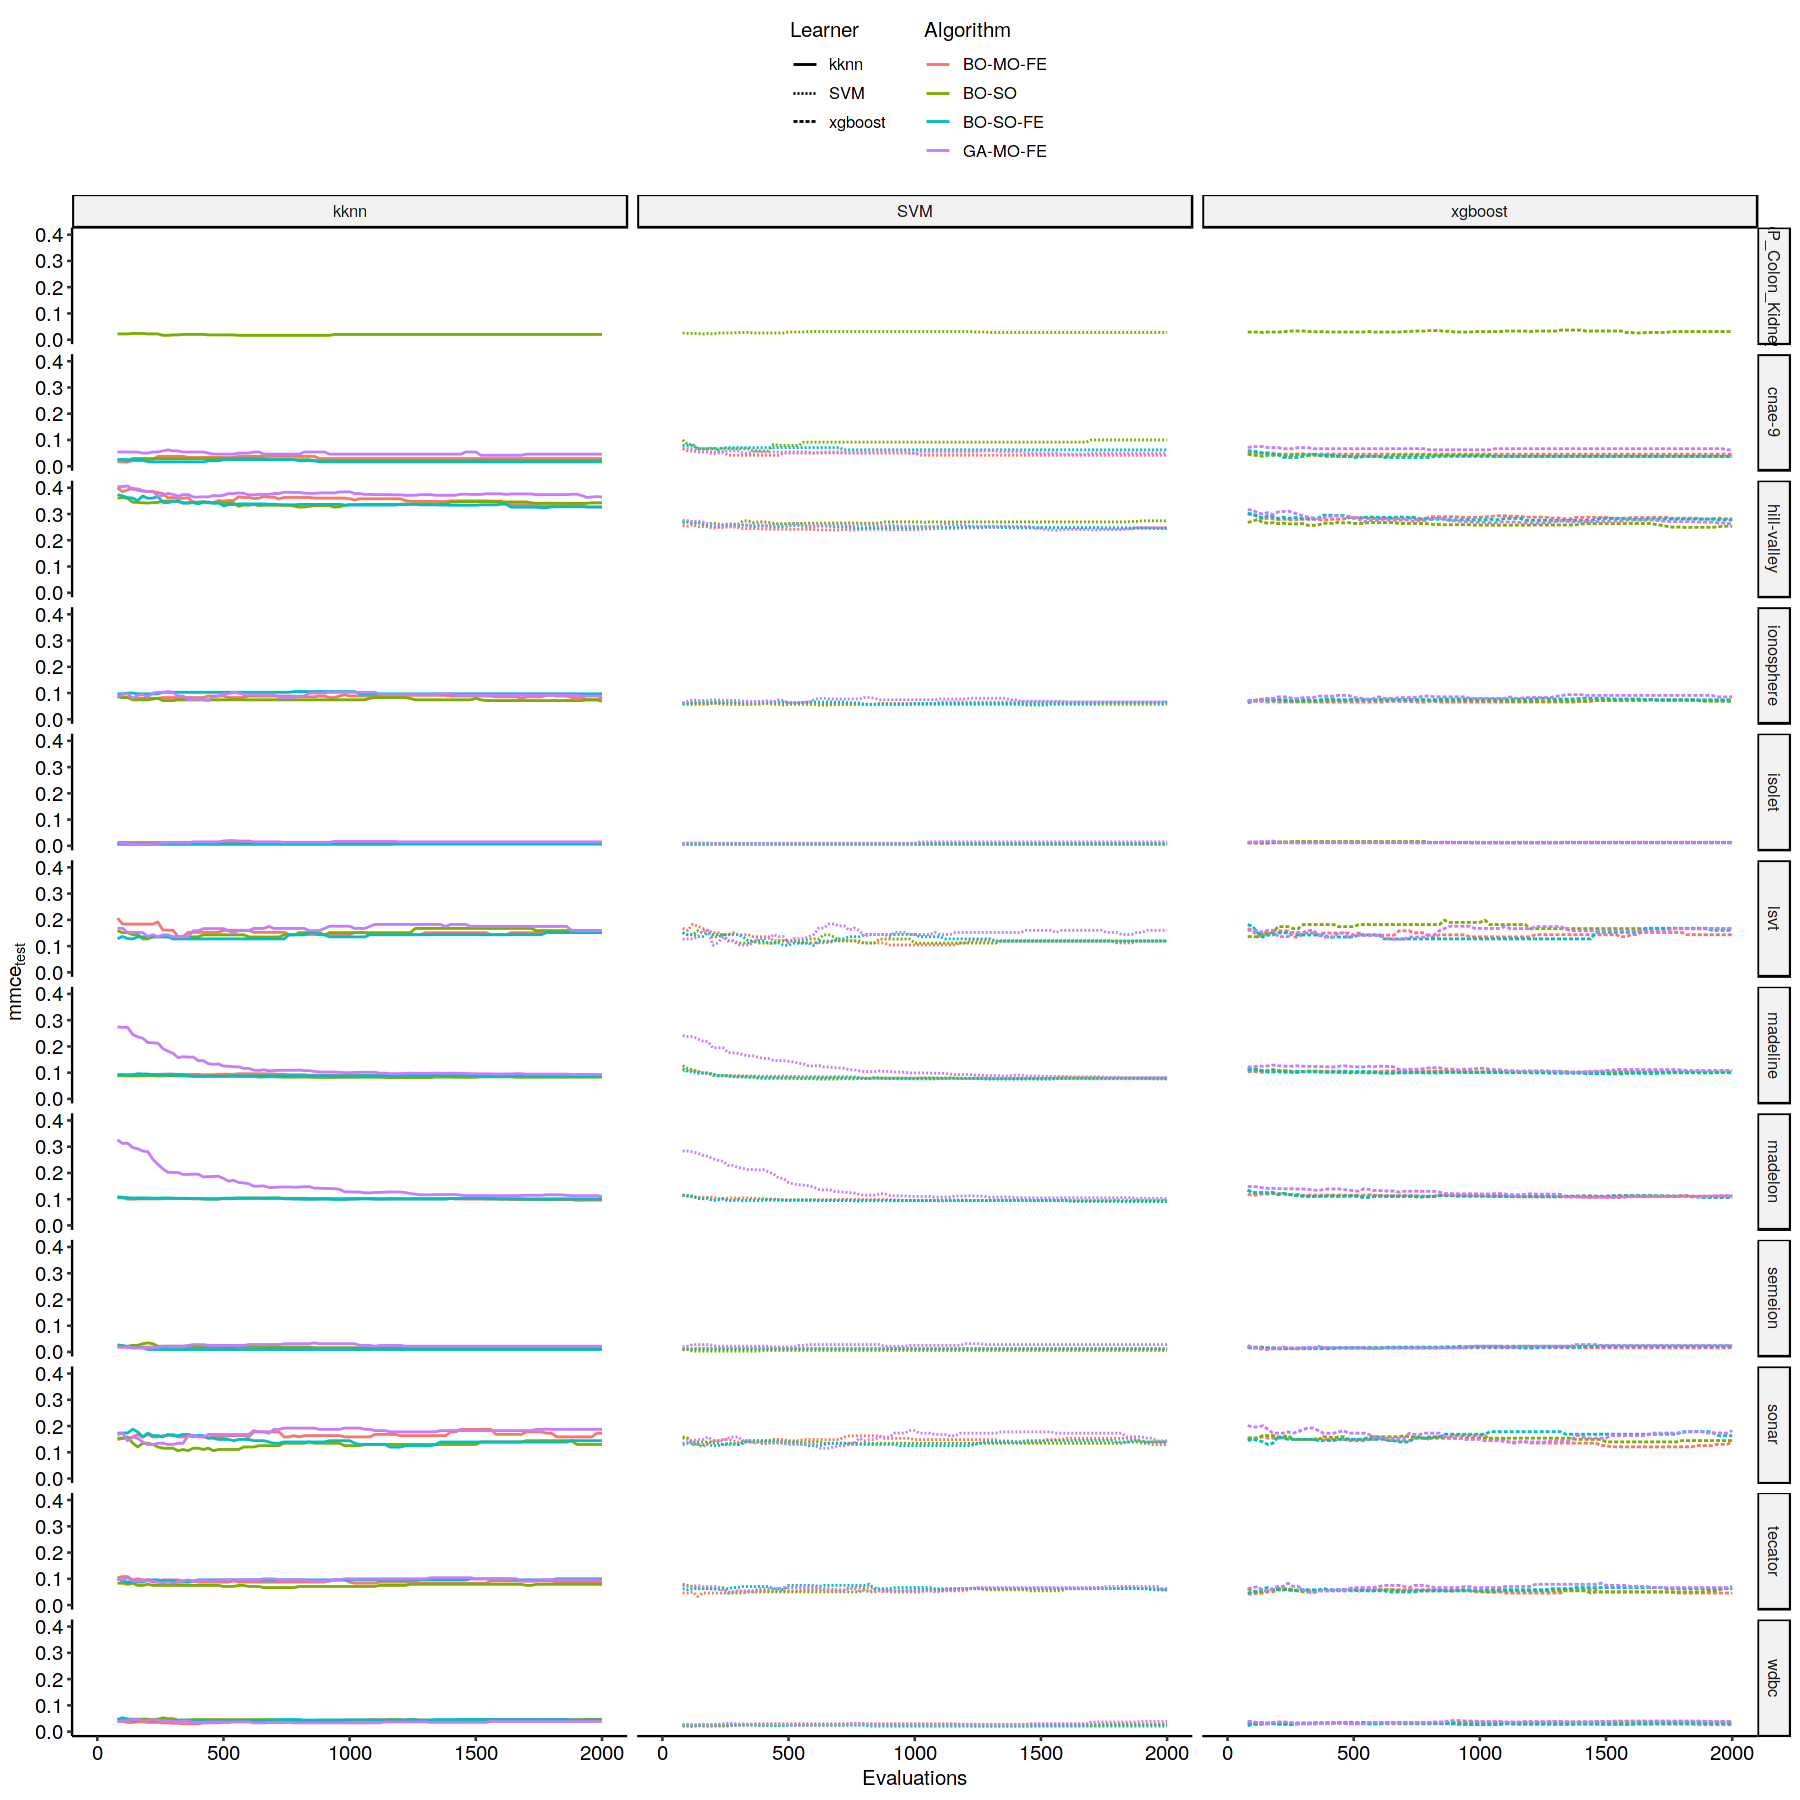

In [49]:
dfr = pops[, .(meanhoutperf = mean(perf.hout.perf)), by = c("learner", "variant", "maxiters", "problem")]
dfr$Variant = sapply(dfr$variant, function(x) {
    if (x %in% c("BO-MO-FE", "GA-MO-FE")) "MO"
    else "SO"
})

# example
p1 = ggplot()
p1 = p1 + geom_line(data = dfr, aes(x = maxiters, y = meanhoutperf, colour = variant, lty = learner), size = 0.6)
p1 = p1 + labs(colour = "Algorithm", lty = "Learner") 
p1 = p1 + xlab("Evaluations") + ylab(expression(mmce[test])) + theme(legend.direction = "vertical")
# p1 = p1 + guides(shape = guide_legend(order = 2),col = guide_legend(order = 1), fill = FALSE)
# p1 = p1 + geom_label(data = res_ovr[evals == 2000, ], aes(x = evals + 150, y = mean.rank, fill = Variant, label = variant), alpha = 0.2)
p1 = p1 + xlim(c(0, 2000))  + facet_grid(problem ~ learner)
p1 
ggsave("viz/appendix/RQ3-best-mmce_all-learners.pdf", p1, width = 10, height = 25)

## 2 Performance-Sparsity-Trade-Off

Motivation: Visualize the drop in performance in favor of a 10\%, 20\%, ..., 90 \% sparser solution instead of considering the dominated hypervolume.  

In [88]:
pops$basevar = sapply(pops$variant, function(x) {
    if (x %in% c("OGHFiFm", "BS5SO")) 
       "NSGA2"
   else 
       "MBO"
})

In [246]:
# bs = pops[variant %in% c("BS5SO", "BS2RF"), ]
# bs = bs[, .SD[which.min(perf.perf)], by = c("job.id")]
# bs$perf.hout.perf = as.numeric(bs$perf.hout.perf)
# bs$meanfeat.propfeat = as.numeric(bs$meanfeat.propfeat)

# bs = bs[, .(mean.hout.perf = mean(perf.hout.perf), mean.propfeat = mean(meanfeat.propfeat)), by = c("learner", "problem", "variant", "basevar")]

In [248]:
# comp = lapply(c(0.05, 0.1, 0.2, 0.3, 0.4, 0.5), function(maxpropfeat) {
#    comp = pops[variant %in% c("OGHFiFm", "BSMOF") & meanfeat.propfeat <= maxpropfeat, ]
#    comp = comp[, .SD[which.min(perf.perf)], by = c("job.id")]
#    comp$perf.hout.perf = as.numeric(comp$perf.hout.perf)
#    comp = comp[, .(mean(perf.hout.perf)), by = c("learner", "problem", "variant", "basevar")]
#    comp$V1 = as.numeric(comp$V1)
#    names(comp)[which(names(comp) == "V1")] = paste("mean.hout.perf", maxpropfeat, sep = "")
#    
#    comp$variant = NULL
#
#    comp
# })

In [249]:
# comp = Reduce(function(...) merge(..., by= c("learner", "problem", "basevar"), all.x=TRUE), comp)
# res = ijoin(comp, bs, by = c("learner", "problem", "basevar"))
# res$variant = NULL

In [60]:
# options(digits = 2L)

# for (bv in c("MBO", "NSGA2")) {
#     towrite = setDT(res)[basevar == bv, c(1:2, 11:10, 4:9)]
#     
#     towrite = format(towrite, digits=2)
#     print(xtable(towrite, type = "latex"), file = paste("viz/RQ3-SOvsMO/", bv, ".tex", sep = ""))
#     write.table(towrite, file = paste("viz/RQ3-SOvsMO/", bv, ".csv", sep = ""))
# }

In [51]:
bs = pops[variant %in% c("BO-SO"), ]
# SHOULD ACTUALLY BE 
# bs = pops[variant %in% c("BO-SO", "BO-SO-FE"), ]

bs = bs[, .SD[which.min(perf.perf)], by = c("job.id")]
bs$perf.hout.perf = as.numeric(bs$perf.hout.perf)
bs$meanfeat.propfeat = as.numeric(bs$meanfeat.propfeat)

In [52]:
comp = lapply(1:10, function(i) {
    comp = data.frame()
    for (lrn in c("xgboost", "SVM", "kknn")) {
        for (prob in datasets) {
            for (var in c("GA-MO-FE", "BO-MO-FE")) {

                # we compare against BO-SO
                # TODO: replace by BO-SO-FE when done
                bestSO = bs[variant == "BO-SO" & replication == i & learner == lrn & problem == prob, ]      
                
                # filter out the right entry in mycomp
                mycomp = pops[variant == var & replication == i & learner == lrn & problem == prob, ]
                # only consider solutions that are sparser than the baseline 
                cat(sprintf("%s, %s, %s \n", lrn, prob, var))
                cat(sprintf("%s <= %s?\n", min(mycomp$meanfeat.propfeat), bestSO$meanfeat.propfeat))
#                [min(meanfeat.propfeat) > bestSO$meanfeat.propfeat, meanfeat.propfeat := 0
                mycomp = mycomp[if (any(meanfeat.propfeat <= bestSO$meanfeat.propfeat))
                                       meanfeat.propfeat <= bestSO$meanfeat.propfeat else 
                                       meanfeat.propfeat == min(meanfeat.propfeat), ]
                print(length(mycomp$perf.perf))
                # get the best 
                mycomp = mycomp[which.min(perf.perf), ]
                # mycomp[, .SD[which.min(perf.perf)], by = c("job.id")]
                
                mycomp$perf.SO = bestSO$perf.hout.perf
                mycomp$propfeat.SO = bestSO$meanfeat.propfeat
                print(nrow(mycomp))
                comp = rbind(comp, mycomp)
            } 
        }
    }
    comp
})

xgboost, sonar, GA-MO-FE 
0.333333333333333 <= 0.532532353942034?
[1] 86
[1] 1
xgboost, sonar, BO-MO-FE 
0.35 <= 0.532532353942034?
[1] 52
[1] 1
xgboost, ionosphere, GA-MO-FE 
0.181818181818182 <= 0.659450773881507?
[1] 97
[1] 1
xgboost, ionosphere, BO-MO-FE 
0.212121212121212 <= 0.659450773881507?
[1] 97
[1] 1
xgboost, hill-valley, GA-MO-FE 
0.1 <= 0.469910807019915?
[1] 77
[1] 1
xgboost, hill-valley, BO-MO-FE 
0.15 <= 0.469910807019915?
[1] 73
[1] 1
xgboost, wdbc, GA-MO-FE 
0.1 <= 0.872793403064625?
[1] 97
[1] 1
xgboost, wdbc, BO-MO-FE 
0.433333333333333 <= 0.872793403064625?
[1] 96
[1] 1
xgboost, tecator, GA-MO-FE 
0.0483870967741935 <= 0.746109065331964?
[1] 97
[1] 1
xgboost, tecator, BO-MO-FE 
0.0806451612903226 <= 0.746109065331964?
[1] 97
[1] 1
xgboost, lsvt, GA-MO-FE 
0.0293159609120521 <= 0.0238540041460993?
[1] 13
[1] 1
xgboost, lsvt, BO-MO-FE 
0.00651465798045603 <= 0.0238540041460993?
[1] 97
[1] 1
xgboost, isolet, GA-MO-FE 
0.00648298217179903 <= 0.151961430488903?
[1] 97
[

In [53]:
comp = do.call(rbind, comp)

In [54]:
comp$perf.hout.perf = as.numeric(unlist(comp$perf.hout.perf))
comp$perf.SO = as.numeric(unlist(comp$perf.SO))
comp$propfeat.SO = as.numeric(unlist(comp$propfeat.SO))
comp$meanfeat.propfeat = as.numeric(unlist(comp$meanfeat.propfeat))

In [55]:
comp

job.id,algorithm,problem,learner,maxeval,cv.iters,filter,initialization,lambda,mu,⋯,evals,absfeat,meanfeat.propfeat,perf.perf,perf.hout.perf,ranks,maxiters,replication,perf.SO,propfeat.SO
<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
106449,mosmafs,sonar,xgboost,2000,10,custom,geom,15,80,⋯,1835,22,0.366666667,0.086257310,0.19047619,1,1840,1,0.14285714,0.53253235
135753,mbo_multicrit,sonar,xgboost,4000,10,custom,NA,NA,NA,⋯,80,21,0.350000000,0.117251462,0.23809524,1,80,1,0.14285714,0.53253235
115845,mosmafs,ionosphere,xgboost,2000,10,custom,geom,15,80,⋯,1340,6,0.181818182,0.047479839,0.11111111,1,1340,1,0.00000000,0.65945077
135783,mbo_multicrit,ionosphere,xgboost,4000,10,custom,NA,NA,NA,⋯,1670,15,0.454545455,0.059879032,0.05555556,1,1680,1,0.00000000,0.65945077
154485,mosmafs,hill-valley,xgboost,2000,10,custom,geom,15,80,⋯,1850,10,0.100000000,0.250458716,0.27049180,1,1860,1,0.26229508,0.46991081
135873,mbo_multicrit,hill-valley,xgboost,4000,10,custom,NA,NA,NA,⋯,1955,23,0.230000000,0.249541284,0.23770492,1,1960,1,0.26229508,0.46991081
177765,mosmafs,wdbc,xgboost,2000,10,custom,geom,15,80,⋯,1490,13,0.433333333,0.019494721,0.01754386,1,1500,1,0.01754386,0.87279340
135903,mbo_multicrit,wdbc,xgboost,4000,10,custom,NA,NA,NA,⋯,140,25,0.833333333,0.021493213,0.01754386,1,140,1,0.01754386,0.87279340
201045,mosmafs,tecator,xgboost,2000,10,custom,geom,15,80,⋯,845,6,0.048387097,0.032251082,0.08333333,1,860,1,0.08333333,0.74610907


In [343]:
# options(digits = 2L)

# for (bv in c("MBO", "NSGA2")) {
    
#     towrite = setDT(comp2)[basevar == bv, c(1:4, 6:5, 7:8)]
#     towrite$variant == NULL
    
#     towrite = format(towrite, digits=2)
#     print(xtable(towrite, type = "latex"), file = paste("viz/RQ3-SOvsMO/", bv, "against_bestSO.tex", sep = ""))
#     write.table(towrite, file = paste("viz/RQ3-SOvsMO/", bv, "against_bestSO.csv", sep = ""))
# }

In [58]:
# aggregated over learners
comp2 = comp[, .(meanperfMO = mean(perf.hout.perf), meanperfSO = mean(perf.SO), maxfeatSO = mean(propfeat.SO), maxfeatMO = mean(meanfeat.propfeat)), by = c("learner", "problem", "variant")]

In [59]:
comp2

learner,problem,variant,meanperfMO,meanperfSO,maxfeatSO,maxfeatMO
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
xgboost,sonar,GA-MO-FE,0.18285714,0.14452381,0.6747647,0.29666667
xgboost,sonar,BO-MO-FE,0.15904762,0.14452381,0.6747647,0.60166667
xgboost,ionosphere,GA-MO-FE,0.08253968,0.06857143,0.6457993,0.21212121
xgboost,ionosphere,BO-MO-FE,0.07412698,0.06857143,0.6457993,0.27878788
xgboost,hill-valley,GA-MO-FE,0.26237637,0.25332611,0.4354054,0.11800000
xgboost,hill-valley,BO-MO-FE,0.28142528,0.25332611,0.4354054,0.25600000
xgboost,wdbc,GA-MO-FE,0.03862782,0.03687343,0.8160985,0.38333333
xgboost,wdbc,BO-MO-FE,0.03336466,0.03687343,0.8160985,0.70333333
xgboost,tecator,GA-MO-FE,0.07083333,0.06250000,0.5400521,0.04516129


In [66]:
for (lrn in unique(comp2$learner)) {
    p = ggplot() + geom_segment(data = comp2[learner == lrn, ], aes(x = meanperfSO, y = maxfeatSO, xend = meanperfMO, yend = maxfeatMO, colour = problem, lty = variant), 
                               arrow = arrow(length = unit(0.03, "npc")), alpha = 0.8)
    # p = p + geom_point(data = dfp, aes(x = meanperfSO, y = maxfeatSO))
    p = p + ylim(c(0, 1)) + xlab(expression(mmce[test])) + ylab("ffrac")
    # p = p + facet_grid(. ~ learner)
    p = p + theme(legend.direction = "vertical", legend.position = "right") 
    p = p + labs(lty = "Variant", colour = "Task") + scale_linetype_manual(values = c(1, 6))
    ggsave(paste("viz/RQ3-arrows-MOagainst_BOSO_", lrn, ".pdf", sep = ""), p, width = 6, height = 4.5)
}


# ggsave("viz/RQ3against_BOSO_aggr.pdf", p, width = 8, height = 5.5)

In [62]:
ggsave("viz/RQ3-arrows-MOagainst_BOSO.pdf", p, width = 6, height = 4.5)


In [352]:
comp2[, mean(meanperfSO),  by=c("variant", "learner")]

variant,learner,V1
<chr>,<chr>,<dbl>
GA-MO-FE,xgboost,0.08265391
BO-MO-FE,xgboost,0.08265391
GA-MO-FE,SVM,0.07859733
BO-MO-FE,SVM,0.07859733
GA-MO-FE,kknn,0.08676474
BO-MO-FE,kknn,0.08676474


In [351]:
comp2[, mean(meanperfMO), by=c("variant", "learner")]

variant,learner,V1
<chr>,<chr>,<dbl>
GA-MO-FE,xgboost,0.09186266
BO-MO-FE,xgboost,0.08287665
GA-MO-FE,SVM,0.08175976
BO-MO-FE,SVM,0.07189625
GA-MO-FE,kknn,0.10103571
BO-MO-FE,kknn,0.09187222
